## MHC II binding prediction using machine learning with sklearn and gibbs sampling

### references:

E. Rouchka, “A Brief Overview of Gibbs Sampling,” Bioinforma. Rev., pp. 1–8, 2008.

M. Nielsen, C. Lundegaard, P. Worning, C. S. Hvid, K. Lamberth, S. Buus, S. Brunak, and O. Lund, “Improved prediction of MHC class I and class II epitopes using a novel Gibbs sampling approach.,” Bioinformatics, vol. 20, no. 9, pp. 1388–97, Jun. 2004.

### datasets:

available at http://tools.iedb.org/static/download/classII_binding_data_Nov_16_2009.tar.gz

In [1]:
import glob,os,math
import pandas as pd
import numpy as np
pd.set_option('display.width', 300)
import sklearn
%matplotlib inline
import pylab as plt
import seaborn as sns
sns.set_style("ticks", {'axes.facecolor': '#F7F7F7','legend.frameon': True})
sns.set_context("notebook", font_scale=1.6)
plt.rcParams['savefig.dpi']=80

from mhcpredict import base,tepitope,utilities,peptides

In [2]:
def diagonal(ax):
    ax.set_ylim(ax.get_xlim())
    ax.plot([0, 1], [0, 1], transform=ax.transAxes,color='red',alpha=0.7)

In [3]:
#wang training data
wang='wangdata'
df=pd.read_csv(os.path.join(wang,'HLA-DRB1-0101.txt'),sep='\t')
df=df[df['SEQ_SEQUENCE'].str.len()==15]
df['SCORE'] = 1-np.log(df.COMP_IC50)/np.log(50000)
df['binder'] = df.SCORE.apply(lambda x: 1 if x <.42 else 0)
df.describe()
#df.head()

,SEQ_AA_LEN,COMP_IC50,SCORE,binder
count,3836,3836.000000,3836.000000,3836.000000
mean,15,2584.657872,0.549269,0.319082
std,0,7543.291525,0.261631,0.466182
min,15,0.040621,0.006253,0.000000
25%,15,17.191215,0.369830,0.000000
50%,15,135.769487,0.546113,0.000000
75%,15,914.429889,0.737111,1.000000
max,15,46728.971960,1.296075,1.000000


In [4]:
#get binding cores
p=df['SEQ_SEQUENCE'].values
# using tepitope scores
pred=base.TEpitopePredictor()
pred.predict(peptides=p,length=15,name='test')
res=pred.data[['peptide','core','score']]
dfc = pd.merge(df,res,left_on='SEQ_SEQUENCE',right_on='peptide')
print dfc[:10]

#using gibbs sampling?


      ALL_ALLELE  SEQ_AA_LEN     SEQ_SEQUENCE     COMP_IC50     SCORE  binder          peptide       core  score
0  HLA DRB1*0101          15  CTGMLKRRLGLMSLS      2.130365  0.930101       0  CTGMLKRRLGLMSLS  CTGMLKRRL  -0.41
1  HLA DRB1*0101          15  LVPVVDGRSNYNTSF  46728.971960  0.006253       1  LVPVVDGRSNYNTSF  VPVVDGRSN  -2.46
2  HLA DRB1*0101          15  LDLGGFSPELSDKYS   6286.506691  0.191651       1  LDLGGFSPELSDKYS  LGGFSPELS  -1.32
3  HLA DRB1*0101          15  LNSYGSFQEFRSNHP   2935.869146  0.262022       1  LNSYGSFQEFRSNHP  FQEFRSNHP  -1.52
4  HLA DRB1*0101          15  EEMINWLNFDSELVR     43.008929  0.652358       0  EEMINWLNFDSELVR  WLNFDSELV   0.68
5  HLA DRB1*0101          15  CAEMLSWLDFDEKLV    155.312876  0.533683       0  CAEMLSWLDFDEKLV  WLDFDEKLV  -2.52
6  HLA DRB1*0101          15  TVKYPNLNDLEKLKD  26608.014520  0.058302       1  TVKYPNLNDLEKLKD  VKYPNLNDL  -2.40
7  HLA DRB1*0101          15  QYAGCSEDEIRQTLD   2847.255948  0.264855       1  QYAGCSEDEIRQTLD  

In [5]:
#encode a sequence using OE
codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
tvd=pd.read_csv('TVD.csv') #combine physicochemical properties
def encodePeptide(seq):       
    s=list(seq)
    #add other aas
    o = list(set(codes) - set(s))
    s = pd.DataFrame(list(seq)+o)
    s = pd.get_dummies(s)[:15]
    s.columns=codes
    #print s    
    s2=tvd.set_index('Property')
    s = pd.concat([s,s2])
    e = s.values.flatten()    
    return e
seq = 'ATGMLKRLLGLMSLA'
e = encodePeptide(seq)
#clf.predict(e)

In [6]:
#encode using blosum
from Bio.SubsMat import MatrixInfo
blosum = MatrixInfo.blosum62
#print blosum
def freqEncodePeptide(seq):       
    s=list(seq)   
    o = list(set(codes) - set(s))
    s = pd.DataFrame(list(seq)+o)
    #print s
    s = pd.get_dummies(s)[:15] 
    s.columns=codes
    #print s
    #s.replace(blosum)
    e = s.values.flatten()
    return e
seq = 'ATGMLKRLLGLMSLA'
e = freqEncodePeptide(seq)

In [8]:
#tvd.set_index('Property')
t = tvd.drop('Property',1).T
#print t

def splitpepstring(x):
    s=pd.Series(list(x[:15])) 
    return s

def encode(r):
    """encode sequence positions"""
    o = list(set(codes) - set(r))
    r = pd.DataFrame(list(r)+o)
    s = pd.get_dummies(r)[:15]
    #print s.index
    e = pd.Series(s.values.flatten())      
    return e

def encodetvd(x):
    """encode physiochemical props"""
    s = t.ix[list(x)] 
    e = pd.Series(s.values.flatten())
    return e

#encode peptides
#x = df['SEQ_SEQUENCE'].apply(splitpepstring)
x = dfc['core'].apply(splitpepstring)
print x.head()
#oe = x.apply(encode,1)
tvde = x.apply(encodetvd,1)

#x = oe.merge(tvde,left_index=True,right_index=True)


   0  1  2  3  4  5  6  7  8
0  C  T  G  M  L  K  R  R  L
1  V  P  V  V  D  G  R  S  N
2  L  G  G  F  S  P  E  L  S
3  F  Q  E  F  R  S  N  H  P
4  W  L  N  F  D  S  E  L  V


In [9]:
x = df['SEQ_SEQUENCE'].apply(splitpepstring)
#x = tvde
#x = dfc['core'].apply(splitpepstring)
#tvde = x.apply(encodetvd,1)
x = pd.get_dummies(x)
#x = x.merge(tvde,left_index=True,right_index=True)

print x.head()
X=x.values
y=df.SCORE.values
lbls = df.binder.values

from sklearn import linear_model
from sklearn import svm
r1 = linear_model.LinearRegression()
r2 = svm.LinearSVR(fit_intercept=False)
c1 = linear_model.LogisticRegression()
#c1 = svm.SVC()

#from sklearn import tree
#clf = tree.DecisionTreeRegressor()

#Xtrain = X[2500:]
#ytrain = y[2500:]
#r1.fit(Xtrain, ytrain)
#r2.fit(Xtrain, ytrain)
print r1
print r2


   0_A  0_C  0_D  0_E  0_F  0_G  0_H  0_I  0_K  0_L  ...   14_M  14_N  14_P  14_Q  14_R  14_S  14_T  14_V  14_W  14_Y
0    0    1    0    0    0    0    0    0    0    0  ...      0     0     0     0     0     1     0     0     0     0
1    0    0    0    0    0    0    0    0    0    1  ...      0     0     0     0     0     0     0     0     0     0
2    0    0    0    0    0    0    0    0    0    1  ...      0     0     0     0     0     1     0     0     0     0
3    0    0    0    0    0    0    0    0    0    1  ...      0     0     1     0     0     0     0     0     0     0
4    0    0    0    1    0    0    0    0    0    0  ...      0     0     0     0     1     0     0     0     0     0

[5 rows x 300 columns]
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=False,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
auc: 0.717045454545
LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=False,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)
auc: 0.734158561745


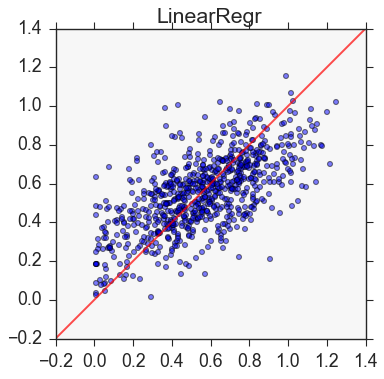

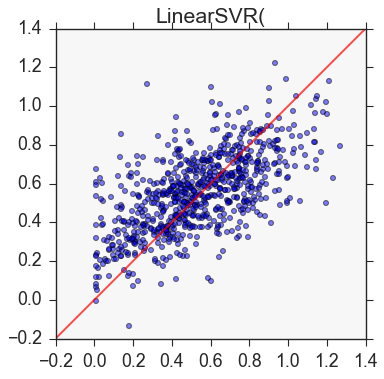

In [10]:
from sklearn import cross_validation
#prediction
def predict(x,i):
    t=x.values[i]
    #print x[:2]
    #print x.values[i]
    print r1.predict(t)

#predict(x,0)

def testClf(clf, X, y):
    """test classifier"""
    Xtrain, Xtest, ytrain, ytest = cross_validation.train_test_split(X, y, test_size=0.2)  
    scores = cross_validation.cross_val_score(clf, X, y, cv=10, scoring='roc_auc')
    print scores
    print 'mean auc:', np.mean(scores)
    return
    
def testRegr(r, X, y): 
    """test regression"""
    print r
    Xtrain, Xtest, ytrain, ytest = cross_validation.train_test_split(X, y, test_size=0.2)    
    r.fit(Xtrain, ytrain)    
    f,ax=plt.subplots(figsize=(5,5))
    pred = r.predict(Xtest)
    ax.scatter(ytest, pred, linewidth=1, alpha=0.5)
    ax.set_title(str(r)[:10])
    diagonal(ax)
    #auc
    true = pd.Series(ytest).apply(lambda x: 1 if x <.42 else 0)
    score = pd.Series(pred).apply(lambda x: 1 if x <.42 else 0)
    print 'auc:',sklearn.metrics.roc_auc_score(true, score)
    sklearn.metrics.roc_curve(true, score, pos_label=1)    
    #scores = cross_validation.cross_val_score(r, X, true, cv=5, scoring='roc_auc')
    #print scores

testRegr(r1, X, y)
testRegr(r2, X, y)
#testClf(c1, X, lbls)


In [11]:
def getScores(sequence, regr):
    """Score multiple fragments of a sequence"""

    peptide, s = peptides.createFragments(seq=sequence, length=15)
    scores=[]
    pos=0
    for p in peptide: 
        e = encodePeptide(p)
        sc = regr.predict(e)[0]        
        scores.append((p,pos,sc))
        pos+=1
    return scores

In [ ]:
r1.fit(X, y)
from Bio import SeqIO
rec = SeqIO.read(open("test.fa", "rU"), "fasta")
seq = str(rec.seq)
sc = getScores(seq, r2)
res=pd.DataFrame(sc,columns=['sequence','pos','score'])
res.sort('score',ascending=False)[:10]

In [16]:
pred=base.NetMHCIIPanPredictor()
pred.predict(sequence=seq,length=15,name='test')
res2=pred.data

netMHCIIpan -s -length 15 -a DRB1_0101 -f tempseq.fa


In [ ]:
y=res.sort('pos')
x=res2.sort('pos')
f,ax=plt.subplots(figsize=(6,6))
ax.scatter(x['1-log50k(aff)'],y.score,c='seagreen')
ax.set_xlabel('netmhciipan')
ax.set_ylabel('sklearn')
#diagonal(ax)

In [20]:
#gibbs sampling for mhc motif
#see  E. Rouchka, “A Brief Overview of Gibbs Sampling” 2008

S = ['ACCATGACAG','GAGTATACCT','CATGCTTACT','CGGAATGCAT']
codes = ['A','T','G','C']
#S = list(df['SEQ_SEQUENCE'].values[:100])

import random
def getSubSeqs(x, idxs):    
    seqs = [i[j:j+w] for i,j in zip(x,idxs)]
    return seqs

def getcountmatrix(a):
    #create freq matrix from seqs
    m = [[r.str.contains(c).sum() for c in codes] for i,r in a.T.iterrows()]    
    m = pd.DataFrame(m,columns=codes)
    return m.T

#print motifs
def printmotifs(S,idxs):
    for s,i in zip(S,idxs)[:10]:   
        x1=s[0:i]; x2=s[i+w:l]
        m=s[i:i+w]
        print("%s\x1b[31;1m%s\x1b[0m%s" %(x1,m,x2))
        
w=7
l=10
N=len(S)
B=4.0

#initialise motif positions randomly
idxs = [random.choice(xrange(l-w)) for s in S]
print idxs[:10]
run=1
for run in range(1,5):
    print 'run', run
    for seq in S:    
        ind = S.index(seq)        
        #print seq
        X=S[:]
        del X[ind]
        xdf = pd.DataFrame([list(s) for s in X])
        
        #get residue counts
        sub = getSubSeqs(X, idxs)
        sub = pd.DataFrame([list(s) for s in sub])
        c = getcountmatrix(sub)
        #print c    

        #get background counts by masking xdf
        bg = []
        for i,r in xdf.iterrows():
            j=idxs[i]
            x = r[range(0,j)+range(j+w,l)]
            bg.append(x)
        bg = pd.DataFrame(bg)
        #print bg
        cb = getcountmatrix(bg)
        cb = cb.sum(1)
        #print cb

        #predictive update step
        #get probability tables for current motifs
        p = c.apply(lambda x: (x+1.0)/(N-1+B),1)     
        pb = cb.apply(lambda x: (x+1.0)/(x.sum()+B),1)
        p['bg'] = pb
        #print p

        #sampling step
        #get a weight for each motif in current sequence
        a=np.empty(l-w+1)
        for i in range(0,l-w+1):
            s = list(seq[i:i+w])
            #print s, i
            pi = [p.ix[s[j]][j] for j in range(len(s))]        
            p0 = [pb.ix[s[j]] for j in range(len(s))]
            a[i] = np.array(pi).prod()/np.array(p0).prod()
        a = a/a.sum()
        if ind<4:
            print seq, a
        #use weights to update motif for this sequence 
        new = np.random.choice(range(0,l-w+1), p=a)
        idxs[ind] = new
        #randomise remaining motifs again?
        #for i in range(ind+1,len(S)):
            #idxs[i] = random.choice(xrange(l-w))
        #print idxs[:20]
    #get alignment log-likelihood
    #F = 
    printmotifs(S,idxs)
    run+=1


[0, 2, 0, 2]
run 1
ACCATGACAG [ 0.13422819  0.16107383  0.20134228  0.5033557 ]
GAGTATACCT [ 0.48504446  0.33953112  0.08488278  0.09054163]
CATGCTTACT [ 0.51489869  0.16090584  0.01907032  0.30512515]
CGGAATGCAT [ 0.24004267  0.00889047  0.34139403  0.40967283]
ACCATGACAG
GAGTATACCT
CATGCTTACT
CGGAATGCAT
run 2
ACCATGACAG [ 0.00937082  0.12851406  0.6746988   0.18741633]
GAGTATACCT [ 0.53667263  0.0417412   0.0208706   0.40071556]
CATGCTTACT [ 0.51489869  0.16090584  0.01907032  0.30512515]
CGGAATGCAT [ 0.1267628   0.01188401  0.77008398  0.09126921]
ACCATGACAG
GAGTATACCT
CATGCTTACT
CGGAATGCAT
run 3
ACCATGACAG [ 0.00738007  0.11808118  0.79704797  0.07749077]
GAGTATACCT [ 0.07776428  0.03888214  0.00850547  0.87484812]
CATGCTTACT [ 0.91525424  0.00423729  0.00423729  0.07627119]
CGGAATGCAT [ 0.0359743   0.00299786  0.0359743   0.92505353]
ACCATGACAG
GAGTATACCT
CATGCTTACT
CGGAATGCAT
run 4
ACCATGACAG [ 0.03153153  0.43243243  0.37837838  0.15765766]
GAGTATACCT [ 0.6126021   0.16336056  0

In [ ]:
import weblogolib as wl
fin = open('align.fa') 
seqs = wl.read_seq_data(fin)  
data = wl.LogoData.from_seqs(seqs) 
options = wl.LogoOptions() 
options.title = "test"
format = wl.LogoFormat(data, options) 
fout = open('logo.png', 'w')
wl.png_formatter( data, format, fout)
